In [ ]:
import pandas as pd
import numpy as np
import sys, os

# Append path for testing - use pyproject for the future
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from analysis_functions import plot_target_vs_predictors, plot_variable_distributions


In [24]:
df = pd.read_csv("../data/bank-full.csv", delimiter=';')

In [25]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# Convert 'y' to numeric for analysis
df["target"] = np.where(df["y"] == "no", 0, 1)

## plot_target_vs_predictors function

In [30]:
predictors =  ["job", "balance", "contact", "duration"]

c:\Users\asacco\OneDrive - Plymouth Rock Assurance Corp\Desktop\repos\analysis_tools\src\analysis_functions.py:197: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
c:\Users\asacco\OneDrive - Plymouth Rock Assurance Corp\Desktop\repos\analysis_tools\src\analysis_functions.py:197: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


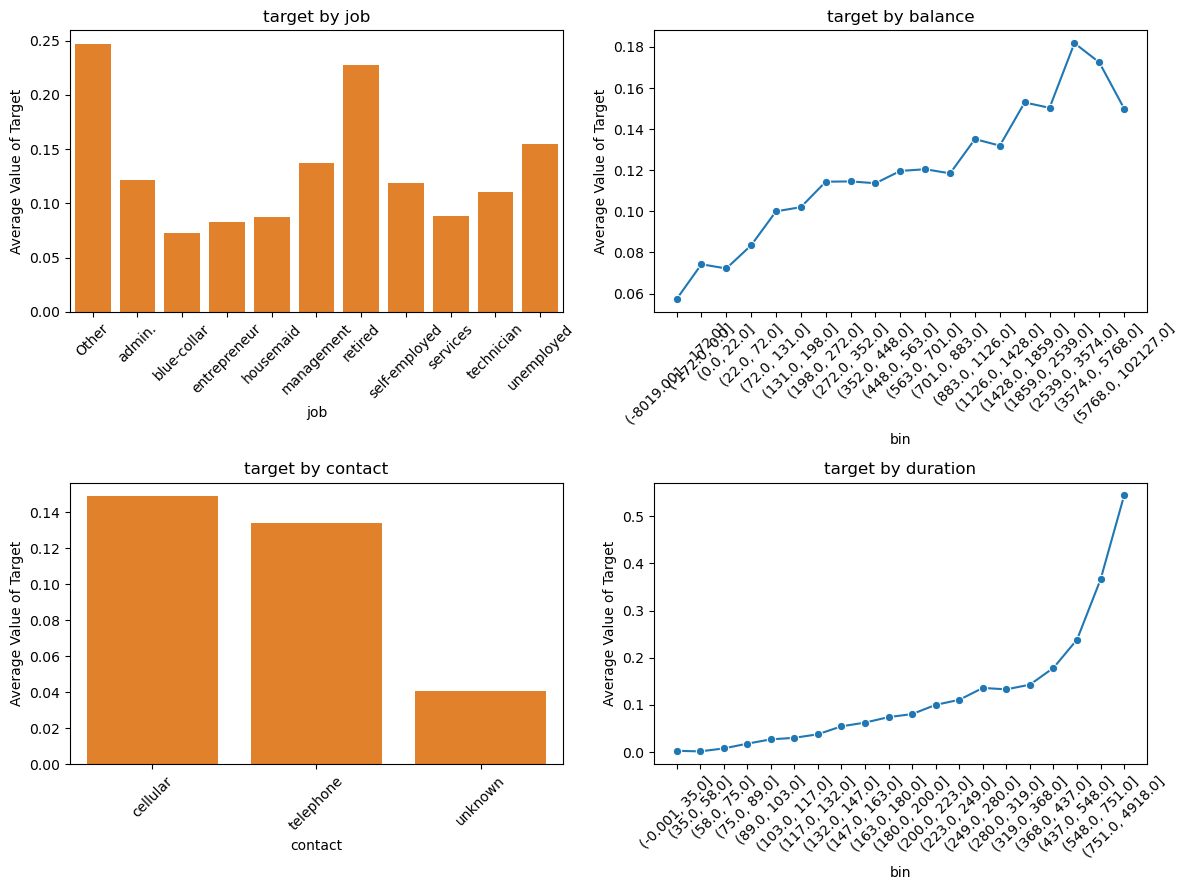

In [ ]:
plot_target_vs_predictors(df, "target", predictors)

## plot_variable_distributions function

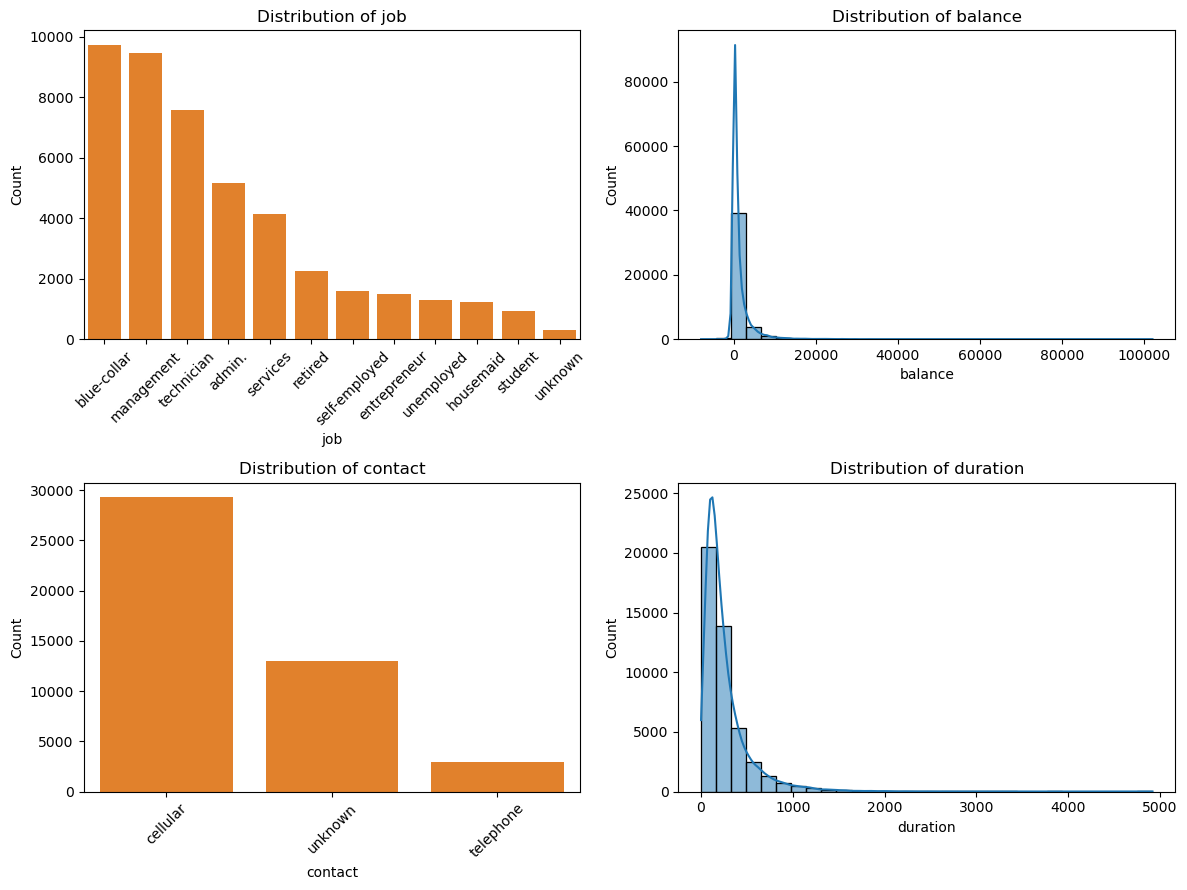

In [31]:
plot_variable_distributions(df, predictors, bins=30)